# <div align='center'> **Analyzing Data from LinkedIn Job Postings**


<div align='center'> December 5th, 2023

**Brigham Young University**

```
Sophie Carter
Morgan Nielsen 
Michelle Wang
Sarah Winters
```

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# **Introduction**

## **Background**

&emsp; &nbsp; LinkedIn, established in 2002, has evolved into a pivotal platform for professionals to connect, network, and explore employment opportunities. With over 800 million members worldwide, LinkedIn remains a powerhouse in the realm of professional social networking. The platform serves as a dynamic repository of job postings, providing a comprehensive snapshot of the global employment landscape. Job overviews on LinkedIn encapsulate a wealth of information, offering detailed insights into the skill sets, qualifications, and responsibilities associated with various positions. As the professional world continues to embrace digital transformation, the sheer volume of data generated by LinkedIn job postings becomes an invaluable resource for researchers and organizations seeking to gain a nuanced understanding of labor market trends.


## **Motivation**

&emsp; &nbsp; As college seniors who are navigating challenges of job applications for entry-level positions, our motivation for undertaking this project is deeply rooted in our personal experiences and the collective anxiety associated with the transition from academia to the professional sphere. Recognizing the significance of securing gainful employment post-graduation, we, as a group, sought to explore a topic that not only resonated with our immediate concerns but also allowed us to leverage our skills in data analysis and machine learning. Initially, our research led us to consider mapping unemployment trends among newly graduated students. However, we encountered obstacles in obtaining clear and comprehensive data, coupled with a lack of robust techniques to effectively analyze this aspect of the job market.
Upon furthering our research, we found a dataset containing LinkedIn job postings from the year 2023. This discovery prompted a shift in our focus, steering us towards the prospect of predicting salary ranges for entry-level positions—a pivotal aspect of the employment equation that directly impacts our cohort. The availability of real-time data from a platform as influential as LinkedIn presented a unique opportunity to apply machine learning algorithms to decipher patterns and trends in salary expectations. Our motivation stems from a desire to contribute not only to our academic pursuits but also to address a practical and immediate concern shared by many in our position—deciphering the salary landscape of entry-level job opportunities in 2023.

## **Overview**

&emsp; &nbsp; We had three main questions that we wanted to answer throughout this paper. First, we wanted to determine if our dataset could help us create a model to predict the formatted experience level based on the minimum and maximum salaries. We also wanted to observe the other way around—how our model can predict salary ranges based on information like location, experience level, and description. Finally, we wanted to determine common words in job descriptions and necessary skills, to be able to determine entry-level jobs; our greatest interest here is specifically in entry-level jobs, since in our personal job hunting experiences, we have run across job descriptions that contradict the formatted experience level. Though we had three questions in mind, we focus the most time on our first question, and hope to be able to answer the other two in the future.


# **The Data**

## **Data Description**

&emsp; &nbsp; Originally, we were going to use two datasets—one about underemployment and one that included LinkedIn job postings from 2023. However, we realized after our proposal and looking more closely at the data that the underemployment dataset wouldn’t be very relevant with the information we could extract from the second dataset. The LinkedIn dataset is a record of over 33,000 job postings spread out between two separate days in 2023 that are months apart. The dataset includes 27 features total, though we mostly used minimum salary, maximum salary, formatted experience level, job description, location, and necessary skills listed. 

## **Data Preparation**

&emsp; &nbsp; Unfortunately, many features in the dataset have hundreds or thousands of NaN values. To observe which columns had the most missing data, we used the pandas feature ```.isna().sum()``` to observe the list of features and the number of missing values listed for each. 

In [15]:
job_postings_data = pd.read_csv('job_postings.csv')

In [16]:
# look at the missing data
missing_data = job_postings_data.isna().sum()
print(missing_data)

job_id                            0
company_id                      366
title                             0
description                       1
max_salary                    10365
med_salary                    14905
min_salary                    10365
pay_period                     9384
formatted_work_type               0
location                          0
applies                        7186
original_listed_time              0
remote_allowed                13546
views                          2763
job_posting_url                   0
application_url                6091
application_type                  0
expiry                            0
closed_time                   14958
formatted_experience_level     4902
skills_desc                   15742
listed_time                       0
posting_domain                 6842
sponsored                         0
work_type                         0
currency                       9384
compensation_type              9384
dtype: int64


&emsp; &nbsp; The most important data to us were those corresponding with description, salary, experience level, and skills. Because of this, we originally looked at the rows that had this data missing, and dropped the NaN values for description, and then the data for maximum salary. After looking at the missing data again, we noticed that the NaN values for maximum salary were the same rows as the missing minimum salary data, so there weren't any missing values in either salary column after dropping the missing maximums. The median salary data felt less important to our goals, so we decided to also drop those values as well. After dropping these NaN values, we felt there were still sufficient data for our analysis, which was part of the reason we felt this dataset was adequate for the predictions and observations we were going to make. However, the formatted experience level column had information we wanted, so we decided to also drop the rows that had NaN values in this column. 

In [43]:
job_postings_data = job_postings_data[job_postings_data['description'].notna()]

# now drop the max, min salaries with NaN values
job_postings_data = job_postings_data[job_postings_data['max_salary'].notna()]

# drop the missing formatted experience data
job_postings_data = job_postings_data[job_postings_data['formatted_experience_level'].notna()]
# we only want to look at the salary that's yearly
job_postings_data['pay_period'].value_counts()
job_postings_data['formatted_work_type'].value_counts()

# filter out the data to just be full-time
full_time_mask = job_postings_data['formatted_work_type'] == 'Full-time'
full_time_data = job_postings_data[full_time_mask]
# print(full_time_data['pay_period'].value_counts())

# multiply the monthly max and min salary  by 12
monthly_mask = full_time_data['pay_period'] == 'MONTHLY'
full_time_data.loc[monthly_mask, ['min_salary', 'max_salary']] *= 12

# multiply the hourly data
hourly_mask = full_time_data['pay_period'] == 'HOURLY'
full_time_data.loc[hourly_mask, ['min_salary', 'max_salary']] *= (40 * 52)

# print(full_time_data.columns)

# now observe all the columns that still have missing data
missing_data = full_time_data.isna().sum()
# print(missing_data)

&emsp; &nbsp; Usually we would want to replace the missing data with something that still had value to our model, so we wouldn't lose any information that could assist with our predictions. However, since our main question ended up surrounding the maximum salary, minimum salary, and formatted experience level columns, we decided that dropping the missing data was the best option, since we could not think of appropriate replacements that would add any use. After dropping these values, we later created one-hot encodings for each type of experience level, so we could go through each one and observe the accuracy of our model’s predictions.


# **Analysis**

&emsp; &nbsp; Our analysis focuses on classifying the six different experience types: are Entry level, Associate, Intern, Executive, Mid-senior level, and Director. Each level of experience has different expected salaries and distributions, so we wanted to observe these differences. It’s expected that as the max salary goes up the more likely the required experience is higher. This prediction is sound while looking at the histograms from some of the data. The director jobs have an expected salary value a lot higher than the entry level jobs. As there is a lot of missing data, we started our predictions based on just entry level jobs because that was our interest, but found that other experience levels are more predictable with our methods.

Text(0.5, 1.0, 'Max Salary Distribution')

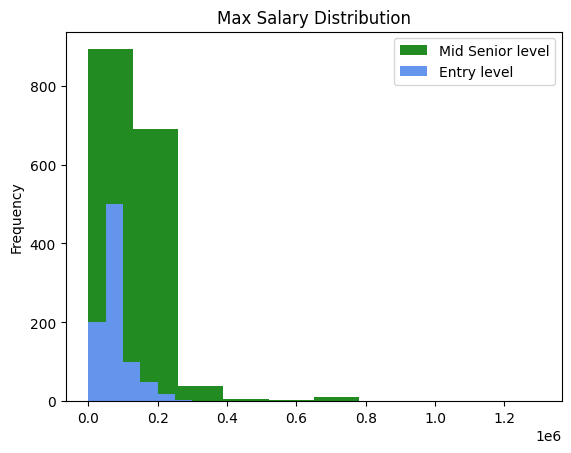

In [36]:
# using the modified job postings data from section 2.2
level_data = full_time_data.groupby("formatted_experience_level")

# create two subplots: entry level and mid-senior level
entry_level_data = level_data.get_group("Entry level")
mid_senior_level_data = level_data.get_group("Mid-Senior level")

plt.figure()
mid_senior_level_data["max_salary"].plot(kind="hist", y="max_salary", label="Mid Senior level", color='forestgreen')
entry_level_data["max_salary"].plot(kind="hist", y="max_salary", label="Entry level", color='cornflowerblue')

plt.legend()
plt.title("Max Salary Distribution")

## **Predicting Experience Level Based on Min and Max Salary**

In our efforts to be able to classify the data into the different experience levels, we first used the random forest classifier to evaluate the precision, recall, and f1 score for each. To do this, we split our data into testing and training sets, where we used 80% for training and 20% for testing. We then created a classification report so we could focus on the two experience levels that had the highest precision, recall, and f1-score.

In [45]:
# create a df with just the salary
salary_columns = full_time_data[["max_salary", "min_salary"]]

# create our X and y
X = salary_columns
y = full_time_data["formatted_experience_level"]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

predictions = forest_model.predict(X_test)
print(f"RandomForestClassifier Classification: \n {classification_report(y_test, predictions)}")


RandomForestClassifier Classification: 
                   precision    recall  f1-score   support

       Associate       0.27      0.22      0.25        89
        Director       0.43      0.18      0.26        55
     Entry level       0.69      0.61      0.65       180
       Executive       0.00      0.00      0.00         4
      Internship       0.00      0.00      0.00         3
Mid-Senior level       0.66      0.80      0.72       316

        accuracy                           0.61       647
       macro avg       0.34      0.30      0.31       647
    weighted avg       0.59      0.61      0.59       647



We can see that the support for Entry level and Mid-Senior level jobs are the highest, as well as the accompanying precision, recall and f1-score values, so we decided to look at them individually by creating a one hot encoding and initializing a random forest model for these columns. Since we wanted the most accurate models possible, we performed a grid search for both entry level and mid-senior level jobs. With this grid search, we can see which parameters create the best model for each level, and find the accuracy and confusion matrix of the predictions.

In [46]:
one_hot_data = pd.get_dummies(full_time_data, columns=['formatted_experience_level'], dtype=int)

In [48]:
# create a function for predicting based off of formatted experience level
def experience_level_predictions(experience_level):
    X = one_hot_data[['min_salary', 'max_salary']]
    y = one_hot_data[experience_level]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    forest_model = RandomForestClassifier()
    forest_model.fit(X_train, y_train)
    # now run a grid search with different parameters
    param_grid = {"n_estimators": [100, 200],
                "max_depth": [4,5,6,7,8],
                "criterion": ['gini', 'entropy']}
    forest_grid = GridSearchCV(forest_model, param_grid, scoring='f1')
    # run the search
    forest_grid.fit(X_train, y_train)
    print(f"Best Parameters: {forest_grid.best_params_}\n")
    print(f"Best Score: {forest_grid.best_score_}\n")

    # predict the labels for the test set
    forest_grid_predicted = forest_grid.predict(X_test)
    # create the confusion matrix
    confusion = confusion_matrix(y_test, forest_grid_predicted)
    print(f"Confusion Matrix: \n{confusion}")

To be able to look at the separate experience levels, we created a one-hot encoding, and ran the above function for ```formatted_experience_level_Entry level``` and ```formatted_experience_level_Mid-Senior level```.

Entry Level

In [49]:
experience_level_predictions('formatted_experience_level_Entry level')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.5930355371630767

Confusion Matrix: 
[[435  32]
 [ 81  99]]


Mid-Senior Level

In [50]:
experience_level_predictions('formatted_experience_level_Mid-Senior level')

Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.7249348874434398

Confusion Matrix: 
[[207 124]
 [ 64 252]]


From this, we can conclude that with minimum and maximum salary as our independent variables, our model has 59.3% accuracy in predicting entry level jobs 72% accuracy in predicting mid-senior level positions. We also see that the best parameters are the same for each of the grid searches, with gini as our best criterion, a maximum depth of 8, and 200 estimators.

# **Limitations**

## **(Un)Suitability of the Data**

&emsp; &nbsp; With regards to each of our three goals for this project, our intentions carried a particular emphasis on being able to model well entry-level positions. However, as our dataset is limited to information on jobs shared with LinkedIn and what LinkedIn reveals to us about each of those jobs, our predictive model demonstrated better accuracy in forecasting mid-senior level positions. In addition, we had desired to create a model predicting salary ranges based on information like location and experience level. We employed combinations from the itertools module to systematically explore various sets of independent variables for constructing our model. However, the resulting performance metrics, including $R^2$ score, $AIC$, $BIC$, and $Ridge$ score, indicated suboptimal model fit. This suggests that given our dataset, the selected combinations of independent variables may not be conducive to effective prediction.

## **Lack of Data**

&emsp; &nbsp; Through the data cleaning process, we learned that the missing values for the formatted experience level overlapped with those of the median salary. This created the problem that when dropping the NaN values in median salary, the formatted experience level columns disappeared, making median salary unusable in the predictions for experience level. Though we don’t know for certain, we guess that the median salary data could have improved the accuracy of our model, so it is unfortunate that this overlap occurred. 

# **Reflection**

&emsp; &nbsp; We acknowledge that there are plenty of imperfections in our model, and we hope to be able to improve it in the future. For example, while cleaning the data, we didn't consider replacing the NaN values from the median salary with any sort of average or other median data we could create. We also learned that sometimes the data will not be able to predict classifications in the way that you expect or desire. There were plenty of features that we could have potentially used, but we were slightly ambitious with how many questions we wanted to answer, and failed to realize we did not have the time or space to do so. 

&emsp; &nbsp; We do believe that our models' predictions have use in the real world, especially for people searching for a job. It was interesting to see the difference between salaries for entry level and mid-senior level positions, and consider the reasoning for it. Additionally, we discovered how difficult it can be to obtain ideal datasets that prove our hypotheses, and found both surprising and unsurprising results.

# **Conclusion**

&emsp; &nbsp; Using a dataset containing LinkedIn job postings from the year 2023, we set out to create two models: 1) predicting experience level based on minimum and maximum salaries, and 2) predicting salary ranges based on information like location and experience level. After training and testing our dataset using random forest classification techniques, we found that our model most accurately predicted mid-senior level positions, followed by entry-level positions, and performed poorly for other experience levels. To improve this project, we could find larger datasets, spread across different domains and with more complete information, so that we would not have to remove many data points due to missing information.

&emsp; &nbsp; In conclusion, while our project has provided valuable insights into predicting salary ranges for entry-level positions using RandomForestClassifiers, GridSearch and a LinkedIn dataset from 2023, the scope of our analysis is limited by time constraints. Future endeavors could extend this work by delving into deeper analyses, such as predicting the level of experience required for a job posting based on its description. Additionally, the dataset is open to exploring the duration of job postings and attempting to predict salary variations based on location or job type. Further research could also hone in on specific industries, like the tech sector, although this might necessitate additional data for a more comprehensive understanding. The potential applications of this dataset are expansive, offering a rich terrain for future investigations that could enhance our comprehension of the intricate dynamics within the job market.


# **Bibliography** 

(1) Kon Arsh. 2023. LinkedIn Job Postings - 2023, Version 9. Retrieved 11/14/23 from https://www.kaggle.com/datasets/arshkon/linkedin-job-postings/data